<a href="https://colab.research.google.com/github/tarangga/Machine-Learning/blob/main/Experiment_Abstractive_Summarization_Method_Teacher_Forcing%2C_Seq2Seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import json 
import re

from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint

from keras.layers import RepeatVector
from keras.models import load_model

from tensorflow.keras.utils import plot_model
import os.path

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Function

In [3]:
def read_jsonl(path):
  with open(path) as f:
    lines = f.readlines()
  return [json.loads(l) for l in lines]
 
def join_summary(arr):
  return '\n'.join(
      [' '.join(row) for row in arr]
  )
 
def join_paragraph(arr):
  return '\n'.join(
      ['\n'.join(
          [' '.join(col) for col in row]
      ) for row in arr]
  )
 
def preprocessing(text):
  text = re.sub('[^\w\d]+', ' ', text)
  return text
 
def flat(arr):
  res = []
  for row in arr:
    for col in row:
      res.append(col)
  return res
 
def select_paragraph(golds, paragraphs):
  gold_paragraph = []
  for j in range(0, len(golds)):
    gold = golds[j]
    text = ''
    for i in range(0, len(gold)):
      if gold[i]:
        text = text + ' '.join(paragraphs[j][i]) + '\n '
    gold_paragraph.append(text.strip())
  
  return gold_paragraph
 
def convert_data(path):
  data = read_jsonl(path)
 
  real_golds = [flat(t['gold_labels']) for t in data]
  pred_golds = [flat(t['pred_labels']) for t in data]
  paragraphs = [flat(t['paragraphs']) for t in data]
 
  return pd.DataFrame(
      {
          'paragraphs': [join_paragraph(arr['paragraphs']) for arr in data],
          'real_extractive': select_paragraph(real_golds, paragraphs),
          'pred_extractive': select_paragraph(pred_golds, paragraphs),
          'summary': [join_summary(arr['summary']) for arr in data]
      }
  )

In [4]:
def preprocessing(text):
  return re.sub(r'[^a-zA-Z0-9 ]', '', text.lower())
 
def clean_first(text, clean):
  for c in clean:
    if text[:len(c)] == c:
      return text[len(c):].strip()
  return text
 
def get_num(text, num):
  arr = text.split()
  return ' '.join(arr[:num])

# Preprocessing

In [5]:
lead_1 = pd.read_csv('/content/drive/MyDrive/Project/Data/Indosum/Extractive/Train/CSV/Lead/lead_1.csv')[['paragraphs', 'summary']]

lead_1.head()

,paragraphs,summary
0,jakarta cnn indonesia dokter ryan thamrin yang...,Dokter Lula Kamal yang merupakan selebriti sek...
1,selfie ialah salah satu tema terpanas di kalan...,Asus memperkenalkan ZenFone generasi keempat...
2,jakarta cnn indonesia dinas pariwisata provins...,Dinas Pariwisata Provinsi Bengkulu kembali men...
3,merdeka.com indonesia corruption watch icw mem...,Indonesia Corruption Watch ( ICW ) meminta Kom...
4,merdeka.com presiden joko widodo jokowi memimp...,Jokowi memimpin upacara penurunan bendera .\nU...


In [6]:
clean = ['jakarta cnn indonesia', 'jakarta antara news', 'jakarta pos kota',
         'juaranet kuala lumpur', 'bandung antara news', 'bandung cnn indonesia',
         'surabaya antara news', 'palembang antara news', 'semarang antara news',
         'makassar antara news', 'washington antara news', 'merdekacom', 'suaracom',
         'rimanews', 'juaranet']

In [7]:
lead_1['paragraphs'] = lead_1['paragraphs'].apply(preprocessing).apply(lambda text: clean_first(text, clean))
lead_1['summary'] = 'sostok _START_ ' + lead_1['summary'].apply(preprocessing) + ' _END_ eostok'

In [8]:
token = Tokenizer(oov_token='<UNK/>')
token.fit_on_texts(lead_1['paragraphs'])

In [9]:
ext_max_len = max([
                  len(text.split()) for text in lead_1['paragraphs']
]) + 1

sum_max_len = max([
                  len(text.split()) for text in lead_1['summary']
]) + 1

In [10]:
ext_token = token.texts_to_sequences(lead_1['paragraphs'])
ext_token = pad_sequences(ext_token, ext_max_len, padding='post')

summ_token = token.texts_to_sequences(lead_1['summary'])
summ_token = pad_sequences(summ_token, sum_max_len, padding='post')

In [11]:
voc = len(token.word_index) + 1
voc

264557

In [12]:
x_tr, x_val, y_tr, y_val = train_test_split(
    np.array(ext_token),
    np.array(summ_token),
    test_size=0.1,
    random_state=0,
    shuffle=True,
)

# Model

In [13]:
"""
Dataset | latent_dim  | embed_dim | lstm  | epochs  | result                    | repeat          | loss    | val_loss
1       | 200         | 350       | 1     | 10      | joko widodo jokowi        | True (test)     | 3.5875  | 4.1893
1       | 200         | 1500      | 1     | 10      | jokowi akan menggelar     | True (test)     | 3.2880  | 4.1336
1       | 100         | 1000      | 1     | 10      | jokowi meminta maaf       | True (test)     | 3.8736  | 4.3531
12      | 50          | 1000      | 1     | 10      | menteri luar negeri retno | True (test)     | 5.1530  | 5.0251
1       | 100         | 200       | 1     | 10      | presiden joko widodo      | True            | 4.1352  | 4.4534
1       | 10          | 200       | 1     | 10      | indonesia yang akan       | True            | 5.1676  | 5.2651
1       | 250         | 350       | 1     | 10      | joko widodo jokowi        | True            | 3.5003  | 4.1754
1       |`200         | 250       | 1     | 10      | widodo dan wakil gubernur | True            | 3.7220  | 4.2473
1       | 100         | 350       | 1     | 10      | perhubungan budi karya    | True
1       | 50          | 350       | 1     | 10      | jenderal jenderal hukum   | True            | 4.3861  | 4.6401
"""

latent_dim = 50 # 50
embedding_dim = 100 # 50

## Encoder

In [14]:
# Encoder
encoder_inputs = Input(shape=(ext_max_len, ))

# Embedding layer
enc_emb = Embedding(voc, embedding_dim,
                    trainable=True)(encoder_inputs)

# Encoder LSTM 1
"""
encoder_lstm1 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output1, state_h1, state_c1) = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output2, state_h2, state_c2) = encoder_lstm2(enc_emb)
"""
# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True,
                     return_sequences=True, dropout=0.4,
                     recurrent_dropout=0.4) 
(encoder_outputs, state_h, state_c) = encoder_lstm3(enc_emb)

## Decoder

In [15]:
# Set up the decoder, using encoder_states as the initial state
decoder_inputs = Input(shape=(None, ))

# Embedding layer
dec_emb_layer = Embedding(voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True,
                    return_state=True, dropout=0.4,
                    recurrent_dropout=0.2)
(decoder_outputs, decoder_fwd_state, decoder_back_state) = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

decoder_dense = TimeDistributed(Dense(voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1163)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1163, 100)    26455700    input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 100)    26455700    input_2[0][0]                    
______________________________________________________________________________________________

## Compile

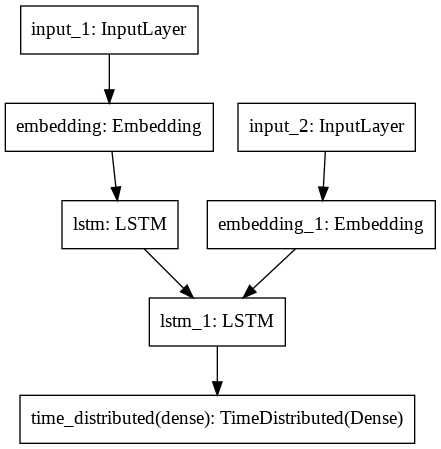

In [16]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
plot_model(model)

## Train

In [ ]:
history = model.fit(
    [x_tr, y_tr[:, :-1]],
    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
    epochs=6,
    validation_data=([x_val, y_val[:, :-1]],
                     y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:
                     , 1:]),
    )

Epoch 1/6
402/402 [==============================] - 2322s 6s/step - loss: 6.9272 - val_loss: 5.6304
Epoch 2/6
 22/402 [>.............................] - ETA: 35:59 - loss: 5.5617

In [ ]:
pd.DataFrame(history.history).to_csv('./history_lead.csv', index=False)
fname = '/content/drive/MyDrive/Project/Model/Indosum/Abstractive/history_{}.csv'
code_history = 1
exists = os.path.isfile(fname.format(''))
while exists:
  code_history = code_history + 1
  exists = os.path.isfile(fname.format(code_history))
  print(exists, fname.format(code_history))

pd.DataFrame(history.history).to_csv(fname.format(code_history), index=False)

## Encoder Decoder Inference

In [ ]:
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs,
                      state_h, state_c])
 
 
decoder_state_input_h = Input(shape=(latent_dim, ))
decoder_state_input_c = Input(shape=(latent_dim, ))
decoder_hidden_state_input = Input(shape=(ext_max_len, latent_dim))
 
dec_emb2 = dec_emb_layer(decoder_inputs)
 
(decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2,
        initial_state=[decoder_state_input_h, decoder_state_input_c])
 
decoder_outputs2 = decoder_dense(decoder_outputs2)
 
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2])

## Save Model

In [ ]:
model.save_weights('/content/drive/MyDrive/Project/Model/Indosum/Abstractive/Train/train') 
encoder_model.save_weights('/content/drive/MyDrive/Project/Model/Indosum/Abstractive/Encoder/encoder')
decoder_model.save_weights('/content/drive/MyDrive/Project/Model/Indosum/Abstractive/Decoder/decoder')

## Load Model

In [ ]:
model.load_weights('/content/drive/MyDrive/Project/Model/Indosum/Extractive-Abstractive/Lead/Train/train')
encoder_model.load_weights('/content/drive/MyDrive/Project/Model/Indosum/Extractive-Abstractive/Lead/Encoder/encoder')
decoder_model.load_weights('/content/drive/MyDrive/Project/Model/Indosum/Extractive-Abstractive/Lead/Decoder/decoder')

# Predict

In [ ]:
reverse_target_word_index = token.index_word
reverse_source_word_index = token.index_word
target_word_index = token.word_index

In [ ]:
def decode_sequence(input_seq):

    (e_out, e_h, e_c) = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))

    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        (output_tokens, h, c) = decoder_model.predict([target_seq]
                + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        if sampled_token != 'eostok':
            decoded_sentence += ' ' + sampled_token

        if sampled_token == 'eostok' or len(decoded_sentence.split()) \
            >= ext_max_len  - 1:
            stop_condition = True

        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        (e_h, e_c) = (h, c)

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0 and i != target_word_index['sostok'] and i \
            != target_word_index['eostok']:
            newString = newString + reverse_target_word_index[i] + ' '

    return newString


def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0:
            newString = newString + reverse_source_word_index[i] + ' '

    return newString

# Result

In [ ]:
import time
start = time.time()
for i in range(0, 10):
    print ('Review:', seq2text(x_tr[i]))
    print ('Original summary:', seq2summary(y_tr[i]))
    print ('Predicted summary:', decode_sequence(x_tr[i].reshape(1,
           ext_max_len)))
    print('---------------------------------------------------------------------')
time.time() -start

In [ ]:
x_tr.shape

In [ ]:
for i in range(0, 10):
    print ('Review:', seq2text(x_val[i]))
    print ('Original summary:', seq2summary(y_val[i]))
    print ('Predicted summary:', decode_sequence(x_val[i].reshape(1,
           ext_max_len)))
    print('---------------------------------------------------------------------')
